# A STATEGY FOR MARKET SEGMENTATION

In [ ]:
"""
step 1: segmentation seed by maturity group
step 2: combine the optimum sowing month
plot  -  a. variety maturity market segmentation
         b. the optimum sowing month
         c. how much segmentation for the top countries 
         d. production benifits for the top counties
        
Plot 4 - Cultivar segmentation and its benefits to maize production
         4a. left: potential benefits by optimizing seed
             right:relationsip between number of segmented market and changes in prodution (Season 1)
         4b. the best segmentation scenario
         4c. which country has the highest benefits from market segmentation
"""
#Clustering seed and sow, identifying the clustering parameters
#Segment market for season 1 - identify the best segmentation parameters
#Info 1 - Find out the optimum setting for segmentation to maximum yield and minimum cv - relationship between parameters - mean/cv
#Info 2 - Segmenation for season 1 maize
#Info 3 - Sgementation distribution between maturity groups
#Info 4 - Segmentation hotspot countries
#Info 5 - Segmentation hotspot regions

In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import scipy.stats as stats
import os
import seaborn as sns
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from sklearn.preprocessing import StandardScaler
import itertools
from statistics import mode
import squarify
import matplotlib.colors as mcolors

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Initial parameters
G1="_GT1"
crop="mz"
fer="wfer_wa38hi40"

# Identify the best parameters for clustering and the appropriate number of market   -   With GT1

In [4]:
"""
Determine the parameters for cluatering
"""

in_dir="D:\\works\\AfricaMzSg\\results\\"+crop+"\\"+fer+"\\"
#data=pd.read_csv("D:/works/AfricaMzSg/input/African5minGrid_SIMUNIT.csv")[['SIMUNIT','POINT_X','POINT_Y','A']]
#data.columns=['SIMUNIT','x','y','A']
#data=data[(data['SIMUNIT']>0)&(data['A']>0)]
#data['sea1_rai_sowmon']=data['ISIMIP_se1_sow']//30
#Win seed and the optimum sow month

for se in [1,2]:
    df=pd.read_csv(in_dir+crop+"_se"+str(se)+"_"+fer+"_dis_withmon"+G1+".csv")[['x','y','s'+str(se)+'c','s'+str(se)+'m']]
    #df=data.merge(temp,how="inner")[['SIMUNIT','x','y','s'+str(se)+'c','s'+str(se)+'m','A']].dropna().reset_index()
    #Combine spatial (x,y) and non-spatial (s1c, s1m) features
    #features=df[['x','y','se'+str(se)+'c','se'+str(se)+'m']].values
    #Standardize the features 
    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(df.values)

    es=[round(x,1) for x in np.arange(0.1,1.1,0.1).tolist()] #granularity of the cluster, samller values create more clusters
    ms=list(range(1,303,10))#[50,100,150,200,250,300] #density threshold higher values result in fewer clusters
    para=list(itertools.product(es,ms))

    df=df.values  #conver df to an array
    colnames=['x','y','s'+str(se)+'c','s'+str(se)+'m']
    for p in range(len(para)): #
        dbscan=DBSCAN(eps=para[p][0],min_samples=para[p][1])
        cluster=dbscan.fit_predict(features_scaled)
        if len(set(cluster)-{-1})>4:  #only concate coluster that greater than 4
            colnames=colnames+['es'+str(para[p][0])+'_ms'+str(para[p][1])+'_cl'+str(len(set(cluster)-{-1}))]
            df=np.hstack((df,cluster.reshape(len(cluster),1)))
    df=pd.DataFrame(df)#.drop(0,axis=1)  #Drop the index column
    df.columns=colnames  #Rename the dataframe
    #    #number of clusters(exclusding noise, which is labeled as -1)
    df.to_csv(in_dir+crop+"_se"+str(se)+"_cul_"+fer+"_cluster_1971-2021"+G1+".csv", index=False)

# Sensitivity of yield benefits to number of market

In [5]:
def IdentifyCulGroup(group):
    c=group['c'].tolist()[0]  #c=str(int(group['c'][0])).replace("-",".")
    m=group['m'].tolist()[0]  #m=str(int(group['m'][0])).zfill(2)
    a=group['A'].mean()
    if m=='' or np.isnan(m):  #if there is no sowing month value
        result=[0]*51  
    else:                    #there is sowing moth value
        m=str(int(m)).zfill(2)
        if c=='' or np.isnan(c):            #no cultivar being identified
            result=group[[col for col in group.columns if 's'+m in col]].mean(axis=1).tolist()  #average across the three groups
        else:                              #month and cultivar are provided
            c=str(int(c)).replace("-",".")
            result=group.loc[:,'m'+c+'s'+m].tolist()
    return(result+[a])

In [6]:
yld=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_"+fer+".csv")
temp=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SIMUNIT_MZ_PhysicalArea.csv")  #area
reportedsow=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SimGrid_Confirmed_5min_4calibration.csv")[['SIMUNIT','ReportedSow_se1m','ReportedSow_se2m']]
reportedsow=reportedsow.merge(temp,how='left')
reportedsow.columns=['SIMUNIT','s1m','s2m','PhysicalArea']
result=pd.DataFrame(columns=['season','es','ms','cul','prod_mean','prod_cv'])
for se in [1,2]:
    #Frist estimate the production with reported sow and mean over the three cultivars
    temp=reportedsow[['SIMUNIT','s'+str(se)+'m','PhysicalArea']]  #reported month and area
    temp.columns=['SIMUNIT','m','A']
    temp.insert(1, 'c', '')                                #inset cultivar columns
    df=yld.merge(temp,how='left')                          #merge to yld dataframe
    temp=df.groupby('SIMUNIT').apply(IdentifyCulGroup).reset_index()   #compute yearly yield
    df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index]).fillna(0)  #conver the dataframe
    prod=np.dot(df.iloc[:,51].T,df.iloc[:,:51])   #estimate production
    result.loc[len(result),]=[se,"","","reportedsow"]+[prod.mean(),prod.std()*100/prod.mean()]
    
    #segmentation and add SIMUNIT column
    seg=pd.read_csv(in_dir+crop+"_se"+str(se)+"_cul_"+fer+"_cluster_1971-2021"+G1+".csv")
    seg['x']=seg['x'].round(2)
    seg['y']=seg['y'].round(2)
    temp=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")[['SIMUNIT','POINT_X','POINT_Y']]
    temp.columns=['SIMUNIT','x','y']
    temp['x']=temp['x'].round(2)
    temp['y']=temp['y'].round(2)
    seg=seg.merge(temp,how='left')
    #Second loop through the cluster type
    for col in seg.columns[seg.columns.str.contains('es')]:
        df=seg.loc[seg[col]>-1, ['SIMUNIT','s'+str(se)+'c','s'+str(se)+'m',col]].reset_index()
        temp=df[[col,'s'+str(se)+'c','s'+str(se)+'m']].groupby([col]).agg(mode).reset_index().astype('int')
        temp.columns=[col,'c','m']
        df=df[['SIMUNIT',col]].merge(temp,how='left').astype('int').drop(col,axis=1)
        df=df.groupby(['SIMUNIT']).agg(mode).reset_index()

        #grids have not been clustered
        temp=reportedsow[~reportedsow['SIMUNIT'].isin(df['SIMUNIT'].tolist())][['SIMUNIT','s'+str(se)+'m']]
        temp.insert(1, 'c', '')
        temp.columns=['SIMUNIT','c','m']
        df=pd.concat([df, temp], ignore_index=True)

        #merge area
        temp=reportedsow[['SIMUNIT','PhysicalArea']]
        temp.columns=['SIMUNIT','A']
        df=df.merge(temp,how='left')
        df=yld.merge(df,how='left')

        #calculate production
        temp=df.groupby('SIMUNIT').apply(IdentifyCulGroup).reset_index()
        df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index]).fillna(0)
        prod=np.dot(df.iloc[:,51].T,df.iloc[:,:51])
        result.loc[len(result),]=[se,float(col.split("_")[0][2:]),int(col.split("_")[1][2:]),
                                  int(col.split("_")[2][2:])]+[prod.mean(),prod.std()*100/prod.mean()]
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\mz_ProdBenefitsToSegmentationPara_"+fer+G1+".csv", index=False)
yld=0
df=0
reportedsow=0
seg=0
temp=0
result=0

0

# PLOTTING - MARKET SEGMENTATION STRATEGY

In [7]:
#merge data and save as a tiff file - function to transfer csv to tif file
def csv2tif(csvinput,outtif,lon_col='x',lat_col='y',value_col='value'):
    """
    Convert a csv file with latitude, longitude and value columns to a GeoTIFF
    """
    df=csvinput#pd.read_csv(csvinput)
    lons=df[lon_col].values
    lats=df[lat_col].values
    values=df[value_col].values
    df=df.dropna() #remove rows with NaN values in latitude, longitude or value
    min_lon,max_lon=np.min(lons),np.max(lons)
    min_lat,max_lat=np.min(lats),np.max(lats)
    resolution=0.1 #define resolution
    rows=int((max_lat-min_lat)/resolution)+1 #create the output raster
    cols=int((max_lon-min_lon)/resolution)+1
   
    raster=np.full((rows,cols),np.nan) #Initialize with NaN values
    #Populate the raster based on dataframe values
    for lat,lon,value in zip(lats,lons,values):
        col=int((lon-min_lon)/resolution)
        row=int((max_lat-lat)/resolution)
        if 0<=row<rows and 0<=col<cols: #check bounds
            raster[row,col]=value
    transform=from_origin(min_lon,max_lat,resolution,resolution) #create transform
    #Write the raster to a GeoTIFF file
    with rasterio.open(
            outtif,
            'w',
            driver='GTiff',
            height=raster.shape[0],
            width=raster.shape[1],
            count=1,
            dtype=rasterio.float32, #Use float32 to stor NaN values
            crs='EPSG:4326',     #Geographic coordinate system
            transform=transform
            ) as dst:
                dst.write(raster,1)

In [24]:
#Final parameters for clustering
in_dir="D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"
seg_col=["es0.2_ms301_cl90","es0.4_ms291_cl23"]  #One of the optimum segmentation strategy
for se in [1,2]:
    #Market distribution
    #process data
    col=seg_col[se-1]
    seg=pd.read_csv(in_dir+crop+"_se"+str(se)+"_cul_"+fer+"_cluster_1971-2021"+G1+".csv") #seg
    seg=seg.loc[seg[col]>-1, ['x','y','s'+str(se)+'c','s'+str(se)+'m',col]].reset_index()
    temp=seg[[col,'s'+str(se)+'c','s'+str(se)+'m']].groupby([col]).agg(mode).reset_index()
    temp.columns=[col,'c','m']
    df=seg[['x','y',col]].merge(temp,how='left')[['x','y','m']]
    df.columns=['x','y','value']
    #Save sow month of the segmenation into a tif file
    csv2tif(df,in_dir+crop+"_se"+str(se)+"_Sowmon_"+fer+G1+"_dis_GT1.tiff")
    #maturity groups, show at 0.5 grid resolution and with type
    seg['x']=seg['x'].round(2)
    seg['y']=seg['y'].round(2)
    temp=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")[['SIMUNIT','POINT_X','POINT_Y']]
    temp.columns=['SIMUNIT','x','y']
    temp['x']=temp['x'].round(2)
    temp['y']=temp['y'].round(2)
    seg=seg.merge(temp,how='left')
    temp=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SimGrid_Confirmed_5min_4calibration.csv")[['SIMUNIT','lat','lon']]
    seg=seg.merge(temp,how='left')
    temp=seg[[col,'s'+str(se)+'c','s'+str(se)+'m']].groupby([col]).agg(mode).reset_index().astype(int)
    temp.columns=[col,'c','m']
    seg=seg[['lat','lon',col]].merge(temp,how='left')#.drop(col,axis=1)
    seg=seg.groupby(['lat','lon']).agg(mode).reset_index()[['lat','lon','c']]
    #Save the cultivar of segmentation into a csv file, with 0.5 grid scale
    seg.to_csv(in_dir+crop+"_se"+str(se)+"_Domcul_"+fer+G1+"_dis_GT1.csv",index=False)

In [26]:
#Compute the productiom benefit for each country
G1="_GT1"
crop="mz"
fer="wfer_wa38hi40"
in_dir="D:/works/AfricaMzSg/results/"+crop+"/"+fer+"/"
seg_col=["es0.2_ms301_cl90","es0.4_ms291_cl23"]  #One of the optimum segmentation strategy
grid=pd.read_csv("D:\\works\\AfricaMzSg\\input\\African5minGrid_SIMUNIT.csv")[['SIMUNIT','POINT_X','POINT_Y']]
grid.columns=['SIMUNIT','x','y']
grid['x']=grid['x'].round(2)
grid['y']=grid['y'].round(2)
reportedsow=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SimGrid_Confirmed_5min_4calibration.csv")
reportedsow=reportedsow[['SIMUNIT','ReportedSow_se1m','ReportedSow_se2m','country','A']]
reportedsow.columns=['SIMUNIT','s1m','s2m','country','A']
yld=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_"+fer+".csv")
#temp=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SIMUNIT_MZ_PhysicalArea.csv")  #area
#reportedsow=reportedsow.merge(temp,how='left')
#Production with the clustering
for se in [1,2]:
    result=pd.DataFrame(columns=['season','country','nmarket','prod_wocluster','prod_cv_wocluster',
                                 'prod_wcluster','prod_cv_wcluster'])
    col=seg_col[se-1]
    #production without the clustering
    temp=reportedsow[['SIMUNIT','s'+str(se)+'m','A','country']]  #reported month and area
    temp.columns=['SIMUNIT','m','A','country']
    temp.insert(1, 'c', '')                                #inset cultivar columns
    df=yld.merge(temp,how='left')                          #merge to yld dataframe
    prod=[]
    prod_cv=[]
    for coun in df['country'].unique():
        temp=df[df['country']==coun]
        temp=temp.groupby('SIMUNIT').apply(IdentifyCulGroup).reset_index()   #compute yearly yield
        temp=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index]).fillna(0)  #conver the dataframe
        temp=np.dot(temp.iloc[:,51].T,temp.iloc[:,:51])
        prod=prod+[temp.mean()]
        prod_cv=prod_cv+[temp.std()*100/temp.mean()]
    result['season']=[se]*len(df['country'].unique())
    result['country']=df['country'].unique()
    result['prod_wocluster']=prod
    result['prod_cv_wocluster']=prod_cv
    
    #prodution with the clustering
    temp=pd.read_csv(in_dir+crop+"_se"+str(se)+"_cul_"+fer+"_cluster_1971-2021"+G1+".csv") #segmentation file
    df=temp.loc[temp[col]>-1, ['x','y',col,'s'+str(se)+'c','s'+str(se)+'m']].reset_index() #remove unclustered row
    #add SIMUNIT columns
    df['x']=df['x'].round(2)
    df['y']=df['y'].round(2)
    df=df.merge(grid,how='inner')[['SIMUNIT',col,'s'+str(se)+'c','s'+str(se)+'m']].astype('int')
    
    temp=df[[col,'s'+str(se)+'c','s'+str(se)+'m']].groupby([col]).agg(mode).reset_index()#.astype('int')  #get value by seg num
    temp.columns=[col,'c','m']
    df=df[['SIMUNIT',col]].merge(temp,how='left')#  #merge identical c and m to seg file
    df=df.groupby(['SIMUNIT']).agg(mode).reset_index()  #group by SIMUNIT
    df0=df  #to keep martket values
    df=df.drop(col,axis=1)  #

    #grids have not been clustered
    temp=reportedsow[~reportedsow['SIMUNIT'].isin(df['SIMUNIT'].tolist())][['SIMUNIT','s'+str(se)+'m']]
    temp.insert(1, 'c', '')
    temp.columns=['SIMUNIT','c','m']
    df=pd.concat([df, temp], ignore_index=True)

    #merge area
    temp=reportedsow[['SIMUNIT','A','country']]
    df=df.merge(temp,how='left')
    df=yld.merge(df,how='left')
    df0=df0.merge(temp)
    #calculate production
    prod=[]
    prod_cv=[]
    nmarket=[]
    for coun in df['country'].unique():
        temp=df[df['country']==coun]  #find country
        temp=temp.groupby('SIMUNIT').apply(IdentifyCulGroup).reset_index()  #get yld
        temp=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index]).fillna(0)
        temp=np.dot(temp.iloc[:,51].T,temp.iloc[:,:51])  #estimate production
        prod=prod+[temp.mean()]
        prod_cv=prod_cv+[temp.std()*100/temp.mean()]
        nmarket=nmarket+[len(df0[df0.country==coun][col].unique())]
    result['prod_wcluster']=prod
    result['prod_cv_wcluster']=prod_cv
    result['nmarket']=nmarket

    result['prod_benefit']=result['prod_wcluster']-result['prod_wocluster']
    result['prod_benefit%']=100*(result['prod_wcluster']-result['prod_wocluster'])/result['prod_wocluster']
    result['cv_benefit%']=100*(result['prod_cv_wcluster']-result['prod_cv_wocluster'])/result['prod_cv_wocluster']
    result.to_csv(in_dir+"mz_se"+str(se)+"_CountryProdBenefitByClustering_"+fer+G1+".csv", index=False)

In [19]:
"""
# Plotting: One of the segmentation strategy
"""
top_country=['Tanzania','South Africa','Congo','Angola','Kenya','Malawi','Zambia','Mali','Nigeria',
             'Ethiopia','Mozambique','Burkina Faso']
africa=gpd.read_file(fig_dir+"CountryBoundaryLines\\ne_110m_admin_0_countries.shp")
africa=africa[africa['CONTINENT']=='Africa']
africa.loc[africa['ADMIN']=='United Republic of Tanzania','ADMIN']="Tanzania"
africa.loc[africa['ADMIN']=='Democratic Republic of the Congo','ADMIN']="Congo"
africa.loc[africa['ADMIN']=='Burkina Faso','ADMIN']="Burkina\nFaso"
africa.loc[africa['LABELRANK']>3,'ADMIN']=""
africa.loc[~africa['ADMIN'].isin(top_country),'ADMIN']=""

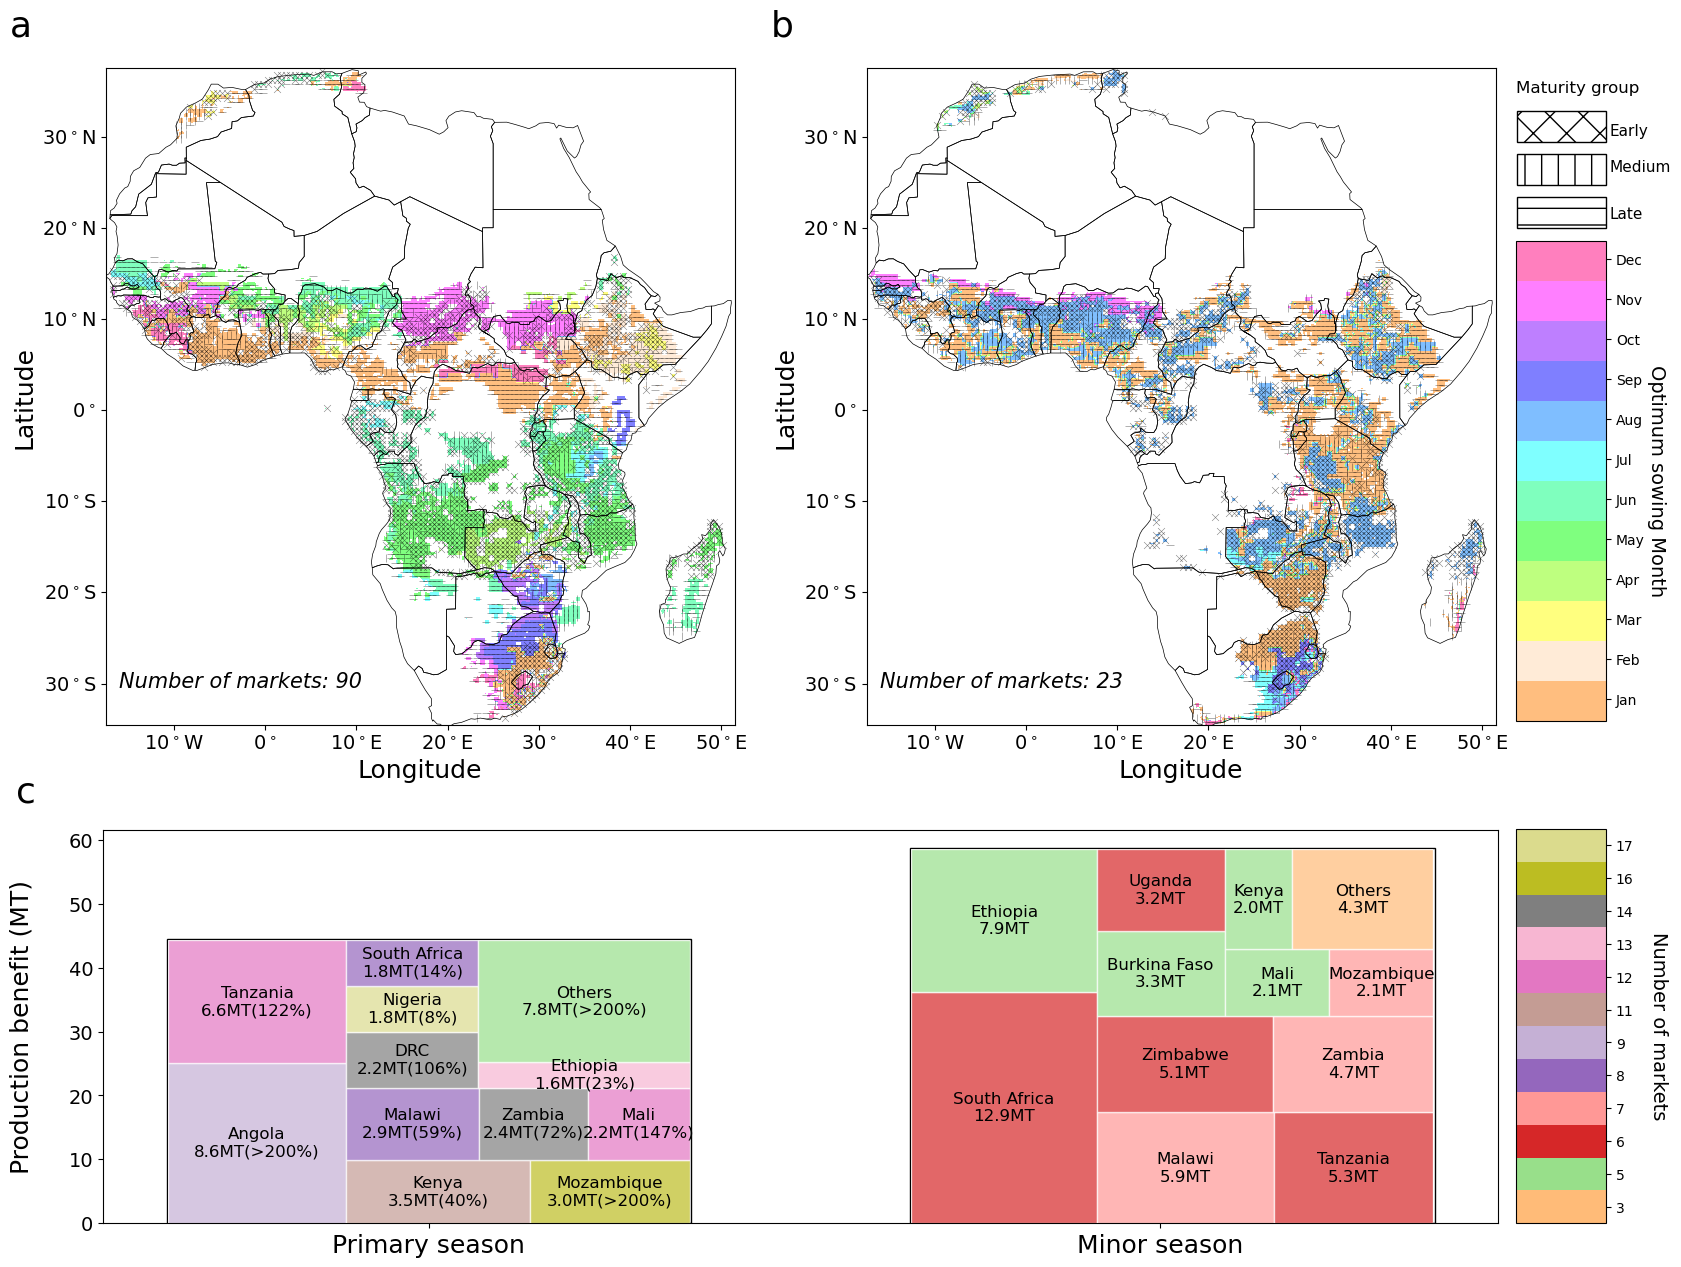

In [92]:
colors=[
    "#FF7F00", #Orange                                                #"#FF0000", #Red
    "#FFD8B1", #Apricot
    "#FFFF00", #Yellow
    "#7FFF00", #Chartreuse
    "#00FF00", #Green
    "#00FF7F", #Spring Green
    "#00FFFF", #Cyan
    "#007FFF", #Azure
    "#0000FF", #Blue
    "#7F00FF", #Violet
    "#FF00FF", #Magenta
    "#FF007F", #Rose
]
#Create a ListedColormap
cmap=ListedColormap(colors)

#colors for the number of market
cmap1 = plt.cm.tab20
colors=cmap1.colors

nmarket=[] 
fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\"
fig = plt.figure(figsize=(18,15))  #,height_ratios=[2,1]
gs=fig.add_gridspec(2,2,height_ratios=[2,1.2])

#Benfits maps at the bottom
ax_bottom=fig.add_subplot(gs[1,:])
bar_width = 0.61
bar_location=[0.1,0.965]
tree_location=[[0.161,0.11,0.290,0.189],[0.574,0.11,0.290,0.2495]]

for se in range(2):
    #Market distribution
    #process data
    ax_top=fig.add_subplot(gs[0,se])
    africa.boundary.plot(ax=ax_top,linewidth=0.5,color='black')
    #for _, row in africa.iterrows():
    #    centroid = row.geometry.centroid
    #    ax_top.text(centroid.x, centroid.y, row['ADMIN'], fontsize=10, ha='center', va='center')
    tif=in_dir+crop+"_se"+str(se+1)+"_Sowmon_"+fer+G1+"_dis_GT1.tiff"
    seg=in_dir+crop+"_se"+str(se+1)+"_Domcul_"+fer+G1+"_dis_GT1.csv"
    with rasterio.open(tif) as src:
        raster_data = src.read(1)  # 读取第一个波段数据
        #get the bounds of the raster
        bounds=src.bounds
        #get the NoData value if it exists
        nodata_value=src.nodata
    img=ax_top.imshow(raster_data,cmap=cmap,vmin=1,vmax=12, extent=[bounds.left,bounds.right,bounds.bottom,bounds.top],alpha=0.5)
    
    type=['x','|','_']
    size=[25,30,30]
    seg=pd.read_csv(seg)
    for cu in [-1,0,1]:
        temp=seg[seg['c']==cu]
        sns.scatterplot(
            data=temp,
            x='lon',
            y='lat',
            color='black',
            marker=type[cu+1],  #+
            s=size[cu+1],
            alpha=0.5,
            ax=ax_top)
    ax_top.set_xlim([-17.5,51.5])
    ax_top.set_ylim([-34.5,37.5])
    ax_top.set_xlabel("Longitude", fontsize=18)
    ax_top.set_ylabel("Latitude", fontsize=18)
    ax_top.set_xticks([-10,0,10,20,30,40,50],
                       ['$10^\circ$W','$0^\circ$','$10^\circ$E','$20^\circ$E','$30^\circ$',
                        '$40^\circ$E','$50^\circ$E'],fontsize=14)
    ax_top.set_yticks([-30,-20,-10,0,10,20,30],
                       ['$30^\circ$S','$20^\circ$S','$10^\circ$S','$0^\circ$','$10^\circ$N','$20^\circ$N',
                        '$30^\circ$N'],fontsize=14)
    ax_top.text(-28,41,chr(97+se),fontsize=26)
    ax_top.text(-16,-33, "Number of markets: "+ seg_col[se].split("_")[2][2:]+"\n",
                  style='italic',fontsize=15) 

    ####################################Country production benefits############################################
    seg=pd.read_csv(in_dir+"mz_se"+str(se+1)+"_CountryProdBenefitByClustering_"+fer+G1+".csv").sort_values('prod_benefit', ascending=False)
    seg['prod_benefit']=seg['prod_benefit']/1000000
    ax_bottom.bar(bar_location[se], seg['prod_benefit'].sum(), width=bar_width, color='white', edgecolor='black', label='Primary season')

    data=seg[seg['prod_benefit']>=1].reset_index().sort_values(by='prod_benefit',ascending=False)
    temp=seg[seg['prod_benefit']<1]
    data.loc[len(data)]=[len(data),1,'Others',temp['nmarket'].mean(),temp['prod_wocluster'].sum(),temp['prod_cv_wocluster'].mean(),
                        temp['prod_wcluster'].sum(),temp['prod_cv_wcluster'].sum(),temp['prod_benefit'].sum(),
                        temp['prod_benefit%'].mean(),temp['cv_benefit%'].mean()]
    #change cell
    data.loc[data['country']=='United Republic of Tanzania','country']='Tanzania'
    data.loc[data['country']=='Democratic Republic of the Congo','country']='DRC'
    if se==0:
        data['prod_benefit%']=data['prod_benefit%'].round(0).astype('int')
        data.loc[data['prod_benefit%']>200,'prod_benefit%']=">200"
    data['nmarket']=data['nmarket'].round(0).astype('int')
    nmarket=nmarket+data['nmarket'].tolist()
    
    se_ax=fig.add_axes(tree_location[se])
    labels=data['country']+"\n"+data['prod_benefit'].round(1).astype('str')+ \
    "MT("+data['prod_benefit%'].astype('str')+"%)"
    if se==1:
        labels=data['country']+"\n"+data['prod_benefit'].round(1).astype('str')+"MT"
    #+"\n"+"Prod. cv benefit: "+  \data['cv_benefit%'].round(1).astype('str')+"%"
    squarify.plot(sizes=data['prod_benefit'],alpha=0.7,label=labels,color=[colors[n] for n in data['nmarket']],
                  edgecolor='white',linewidth=1,text_kwargs={'fontsize':12},ax=se_ax)
    se_ax.axis('off')
ax_bottom.text(-0.38,66,'c',fontsize=26)
ax_bottom.set_ylabel("Production benefit (MT)", fontsize=18,labelpad=25)
ax_bottom.set_xticks([0.1,0.95],['Primary season','Minor season'],fontsize=18)
ax_bottom.yaxis.set_tick_params(labelsize=14)
#For sowing month 
cbar_ax = fig.add_axes([0.91, 0.445, 0.05, 0.32])  # Create a new axes for the colorbar
cbar = fig.colorbar(img, cax=cbar_ax, orientation='vertical')
cbar.set_label('Optimum sowing Month',fontsize=14,rotation=270,labelpad=15)
#cbar.set_ticks(np.arange(0.5, 13.5))
cbar.set_ticks([1.5+(11/12)*x for x in range(12)])
#cbar.set_ticklabels([f'{i}' for i in range(1, 13)])
cbar.set_ticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
# For cultivar maturity group
cultivar_patches = [Patch(facecolor='none', edgecolor='black', hatch=pattern) for pattern in ["x","|","-"]]
legend = fig.legend(handles=cultivar_patches, loc='upper right', bbox_to_anchor=(0.982, 0.88),
                    frameon=False, handletextpad=0, columnspacing=0,labelspacing=0, fontsize=32)
fig.text(0.91,0.864,'Maturity group',fontsize=12)
fig.text(0.962,0.835,'Early', fontsize=11)
fig.text(0.962,0.8110,'Medium', fontsize=11)
fig.text(0.962,0.780,'Late', fontsize=11)
#colorbar for number of market
nmarket=list(set(nmarket))
cbar_ax = fig.add_axes([0.91,0.11,0.05,0.263])
nmarket_cmap=mcolors.ListedColormap([colors[n] for n in nmarket])
norm=mcolors.BoundaryNorm(boundaries=np.arange(0,len(nmarket)+1),ncolors=len(nmarket))
sm=plt.cm.ScalarMappable(cmap=nmarket_cmap,norm=norm)
sm.set_array([])
cbar=fig.colorbar(sm,orientation="vertical",cax=cbar_ax)
cbar.ax.tick_params(which='minor', color='white', labelcolor='white')
cbar.set_ticks([0.5+x for x in range(len(nmarket))])
cbar.set_ticklabels([f'{i}' for i in nmarket])
cbar.set_label("Number of markets",fontsize=14,rotation=270,labelpad=25)
plt.show()
#fig.tight_layout()
fig.savefig(fig_dir+"MS\\wfer\\MS1_mz_MarketSegmentation_"+fer+".png",format="png",dpi=300,bbox_inches='tight', pad_inches=0)
fig.savefig(fig_dir+"MS\\wfer\\MS1_mz_MarketSegmentation_"+fer+".pdf",format="pdf",dpi=300,bbox_inches='tight', pad_inches=0)

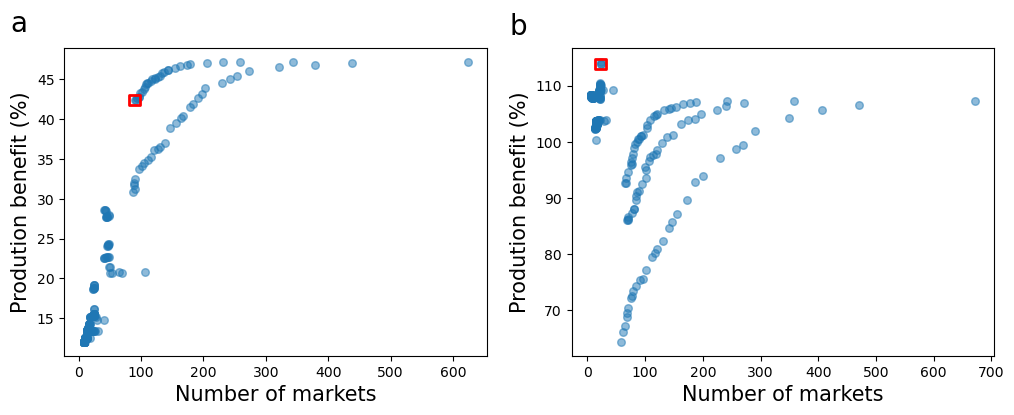

In [88]:
"""
#Supplementary PLOTTING: Benefit response to paramerization
"""
point=[[0.2,301],[0.4,291]]
df=pd.read_csv(in_dir+crop+"_ProdBenefitsToSegmentationPara_"+fer+G1+".csv")

fig, ax = plt.subplots(1, 2, figsize=(12,4))
for se in range(2):
    temp=df[df['season']==se+1]
    bs=temp.loc[temp['cul']=='reportedsow','prod_mean'].tolist()[0]
    temp=temp[temp['cul']!='reportedsow']
    temp['cul']=temp['cul'].astype('int')
    temp['prodbenefit']=100*(temp['prod_mean']-bs)/bs
    
    para=temp[(temp['es']==point[se][0])&(temp['ms']==point[se][1])][['cul','prodbenefit']]
    ax[se].scatter(temp['cul'],temp['prodbenefit'], marker='o',s=30,alpha=0.5)
    ax[se].scatter(para['cul'],para['prodbenefit'],marker='s',s=60,edgecolor='red',facecolor='none',linewidth=2)
    
    ax[se].set_ylabel("Prodution benefit (%)",fontsize=15)
    ax[se].set_xlabel("Number of markets", fontsize=15)
ax[0].text(-110,51,'a',fontsize=20)
ax[1].text(-135,119,'b',fontsize=20)
fig.savefig(fig_dir+"MS\\wfer\\MS1_mz_ClusteringParaSensitivity_"+fer+".png",format="png",dpi=300,bbox_inches='tight', pad_inches=0)
fig.savefig(fig_dir+"MS\\wfer\\MS1_mz_ClusteringParaSensitivity_"+fer+".pdf",format="pdf",dpi=300,bbox_inches='tight', pad_inches=0)

In [ ]:
"""
#Supplementarty PLOTTING: Production, and Production CV benefits across countries
"""

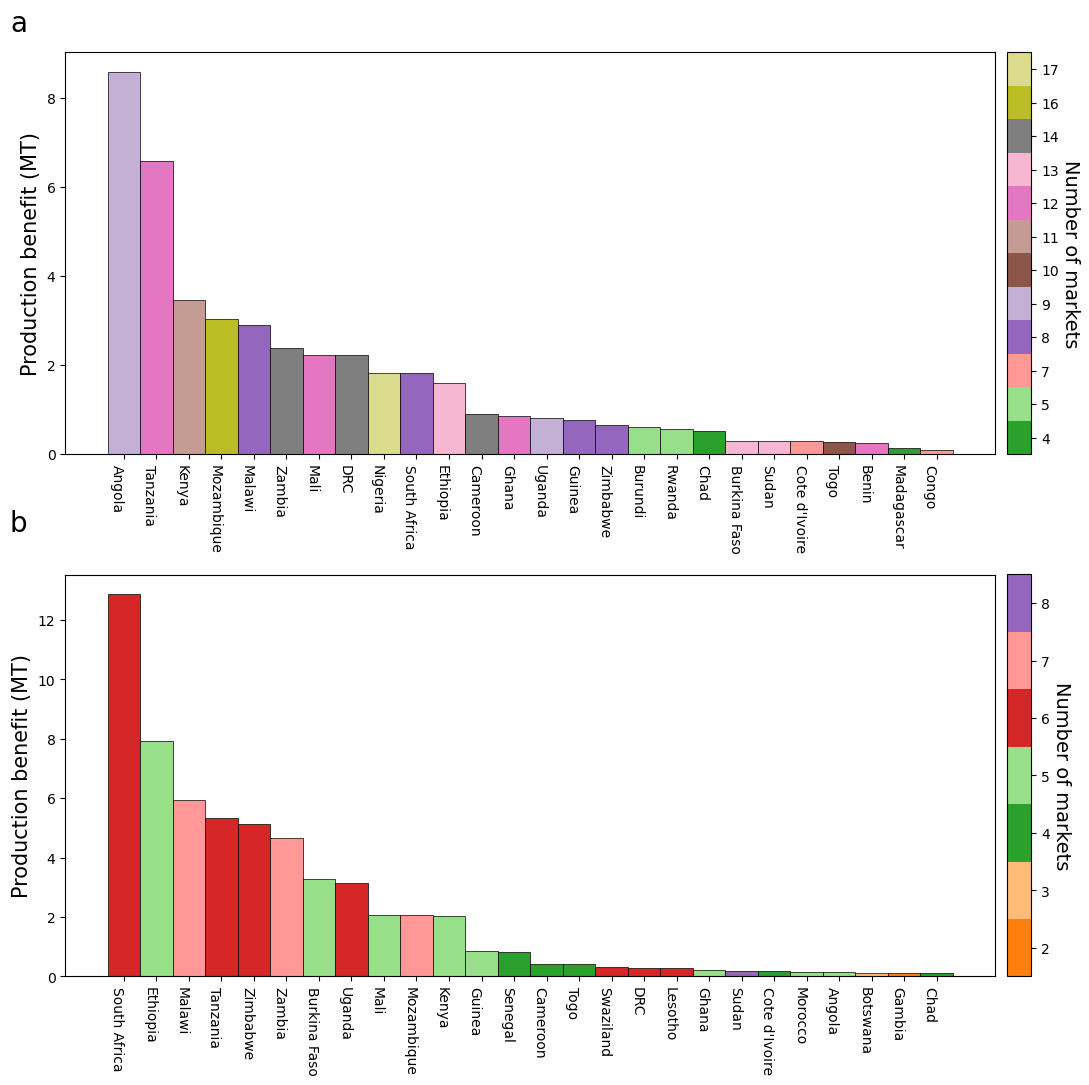

In [83]:
cmap1 = plt.cm.tab20
colors=cmap1.colors

fig, ax = plt.subplots(2, 1, figsize=(12,12))
#for se in range():
for se in range(2):
    seg=pd.read_csv(in_dir+"mz_se"+str(se+1)+"_CountryProdBenefitByClustering_"+fer+G1+".csv").sort_values('prod_benefit', ascending=False)
    seg['prod_benefit']=seg['prod_benefit']/1000000
    seg=seg[seg['prod_benefit']>0.1].replace("United Republic of Tanzania",
                                           "Tanzania").replace("Democratic Republic of the Congo", 
                                                               "DRC").replace("Libyan Arab Jamahiriya","Libya").replace("C??te d'Ivoire",
                                                                                                                         "Cote d'Ivoire")
    bars=ax[se].bar(seg['country'],seg['prod_benefit'],edgecolor='black',color=[cmap1(n) for n in seg['nmarket']],linewidth=0.5,width=1)
    ax[se].set_xticks(seg['country'], seg['country'], rotation=270, ha='right')
    ax[se].set_ylabel('Production benefit (MT)',fontsize=15)
    
    nmarket=seg['nmarket'].tolist()
    nmarket=list(set(nmarket))
    cbar_ax = fig.add_axes([0.91,0.545-se*0.435,0.02,0.335])
    nmarket_cmap=mcolors.ListedColormap([cmap1(n) for n in nmarket])
    boundaries=np.arange(0,len(nmarket)+1)
    norm=mcolors.BoundaryNorm(boundaries,len(nmarket),clip=True)
    sm=plt.cm.ScalarMappable(cmap=nmarket_cmap,norm=norm)
    #sm.set_array([])
    cbar=fig.colorbar(sm,orientation="vertical",cax=cbar_ax)
    #cbar.ax.tick_params(size=0)
    cbar.set_ticks([0.5+x for x in range(len(nmarket))])
    cbar.set_ticklabels([f'{i}' for i in nmarket])
    cbar.set_label("Number of markets",fontsize=14,rotation=270,labelpad=15)
    cbar.ax.tick_params(which='minor', color='white', labelcolor='white')
    
ax[0].text(-3.5,9.5,'a',fontsize=20)
ax[1].text(-3.5,15,'b',fontsize=20)
plt.subplots_adjust(hspace=0.3)
fig.savefig(fig_dir+"MS\\wfer\\MS1_mz_ProdBenefit4all_"+fer+".png",format="png",dpi=300,bbox_inches='tight', pad_inches=0)
fig.savefig(fig_dir+"MS\\wfer\\MS1_mz_ProdBenefit4all_"+fer+".pdf",format="pdf",dpi=300,bbox_inches='tight', pad_inches=0)

In [578]:
nmarket

[3, 4, 6]

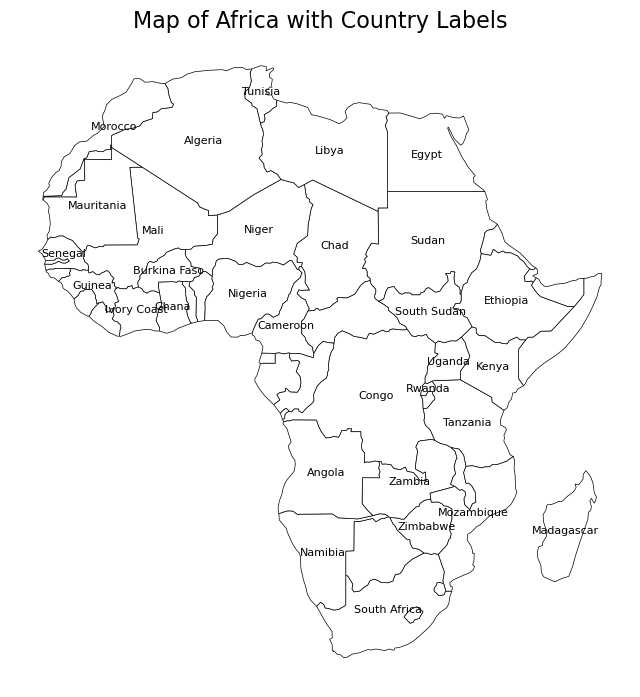

In [340]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Step 1: Load the Africa map shapefile
# You can use GeoPandas' built-in datasets or download a shapefile of Africa

# Step 2: Calculate label positions outside the boundaries
# Create a new column for label positions
def calculate_label_position(row):
    # Get the centroid of the country
    centroid = row.geometry.centroid
    # Offset the label position based on the centroid's location
    if centroid.x > 20:  # Eastern countries
        return Point(centroid.x + 5, centroid.y)
    elif centroid.x < -20:  # Western countries
        return Point(centroid.x - 5, centroid.y)
    elif centroid.y > 0:  # Northern countries
        return Point(centroid.x, centroid.y + 5)
    else:  # Southern countries
        return Point(centroid.x, centroid.y - 5)



# Step 3: Plot the map
fig, ax = plt.subplots(figsize=(8, 10))

#africa['label_position'] = africa.apply(calculate_label_position, axis=1)
africa.plot(ax=ax, color='white', edgecolor='black',linewidth=0.5)

# Step 4: Add labels outside the boundaries
for _, row in africa.iterrows():
    # Draw a line from the centroid to the label position
    #label_pos = row['label_position']
    centroid = row.geometry.centroid
    ax.plot([centroid.x, centroid.x], [centroid.y, centroid.y], color='black', linewidth=0.5)
    # Add the country name at the label position
    ax.text(centroid.x, centroid.y, row['ADMIN'], fontsize=8, ha='center', va='center')

# Step 5: Customize the plot
ax.set_title('Map of Africa with Country Labels', fontsize=16)
ax.axis('off')  # Turn off the axes for a cleaner look

# Step 6: Show the plot
plt.show()

In [337]:
africa.loc[africa['ADMIN']=='United Republic of Tanzania','ADMIN']="Tanzania"
africa.loc[africa['ADMIN']=='Democratic Republic of the Congo','ADMIN']="Congo"
africa.loc[africa['LABELRANK']>3,'ADMIN']=""

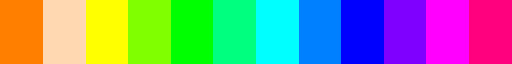

In [310]:
colors=[
    "#FF7F00", #Orange                                                #"#FF0000", #Red
    "#FFD8B1", #Apricot
    "#FFFF00", #Yellow
    "#7FFF00", #Chartreuse
    "#00FF00", #Green
    "#00FF7F", #Spring Green
    "#00FFFF", #Cyan
    "#007FFF", #Azure
    "#0000FF", #Blue
    "#7F00FF", #Violet
    "#FF00FF", #Magenta
    "#FF007F", #Rose
]
#Create a ListedColormap
cmap=ListedColormap(colors)
cmap

In [318]:
seg_col[0].split("_")[2][2:]

'89'

In [60]:
#How production and variability benefits from number of market
#directly read simulated yield file
#first read seg file, select A>0, 
#read yld file, slice season and simunit that A >0, 
#For seg file, find unique SIMUNIT, sc and sm
#Production benefits are estimated based on production with reportred sow, with yield averaged for the three maturity groups
area=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SIMUNIT_MZ_PhysicalArea.csv")
result=pd.DataFrame(columns=['season','es','ms','cul','neg1areashare','prod_mean','prod_cv'])
#df=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_wofer.csv")
#report sow month
reportedsow=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SimGrid_Confirmed_5min_4calibration.csv")[['SIMUNIT','ReportedSow_se1m','ReportedSow_se2m']]
reportedsow.columns=['SIMUNIT','s1m','s2m']
#read yield file
yld=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_"+fer+".csv")
#yield for reported sow
yld0=pd.read_csv("D:\\works\\AfricaMzSg\\output\\mz_yield_ReportedSow_"+fer+".txt",delim_whitespace=True)
yld0=yld0.groupby(['SIMUNIT','sea'])[['yld_'+str(yr) for yr in range(1971,2022)]].mean().reset_index()
for se in [1,2]: #season
    seg=pd.read_csv(in_dir+crop+"_se"+str(se)+"_cul_"+fer+"_cluster_1971-2021"+G1+".csv")
    #loop throug the col
    for col in seg.columns[seg.columns.str.contains('es')]:
        missclusterarea=round(seg[seg[col]==-1]['A'].sum()*100/seg['A'].sum(),1)
        df=seg[['SIMUNIT','s'+str(se)+'c','s'+str(se)+'m',col]]
        df=df.groupby(['SIMUNIT',col]).agg(mode).reset_index()
        #replace unclustered se
        u=df.loc[df[col]==-1,'SIMUNIT'].tolist()
        df.loc[df[col]==-1,'s'+str(se)+'m']=reportedsow[reportedsow['SIMUNIT'].isin(u)]['s2m'].tolist()
        df.loc[df[col]==-1,'s'+str(se)+'c']=2
        df=df.dropna().reset_index()
        temp=pd.DataFrame(columns=['SIMUNIT']+[str(yr) for yr in range(1971,2022)])
        for rowi in range(df.shape[0]):
            simunit=int(df.SIMUNIT[rowi])
            cul=int(df['s'+str(se)+'c'][rowi])
            mon=int(df['s'+str(se)+'m'][rowi])
            if cul<2:  #Long, median and short
                temp.loc[len(temp),]=[simunit]+yld.loc[yld.SIMUNIT==simunit,'m'+str(cul).replace("-", ".")+'s'+str(mon).zfill(2)].tolist()
            else:   #average across the three
                temp.loc[len(temp),]=[simunit]+yld.loc[yld.SIMUNIT==simunit,yld.columns.str.contains('s'+str(mon).zfill(2))].mean(axis=1).tolist()
        temp=temp.merge(area)
        #######################prodution for grids that have been clustered#####################################
        prod=np.dot(temp[['PhysicalArea']].values.T,temp[[str(yr) for yr in range(1971,2022)]].values)/1000000
        #######################production for grids that have not been clustered################################
        #a list contains all seg grid simunit
        u=temp.loc[:,'SIMUNIT'].dropna()         #simunit that is in the seg 0
        u=[int(x) for x in list(set(u.tolist()))]  #cover simunit to integer
        df=yld0[(yld0['sea']==se)&(~yld0['SIMUNIT'].isin(u))]   #select grids with season and that are not in the seg file
        df=df.merge(area,how='inner')  #merge area
        prod0=np.dot(df[['PhysicalArea']].values.T,df[['yld_'+str(yr) for yr in range(1971,2022)]].values)/1000000
        prod=prod+prod0
        result.loc[len(result),]=[se,float(col.split("_")[0][2:]),int(col.split("_")[1][2:]),
                                  int(col.split("_")[2][2:])]+[missclusterarea,prod.mean(),prod.std()*100/prod.mean()]
        
#Add production across the three maturity groups with reported sow, this used as the reference for comparison.
for se in [1,2]: #season
    df=reportedsow[['SIMUNIT','s'+str(se)+'m']].dropna().reset_index()
    temp=pd.DataFrame(columns=['SIMUNIT']+[str(yr) for yr in range(1971,2022)])
    for rowi in range(df.shape[0]):
        simunit=int(df.SIMUNIT[rowi])
        mon=int(df['s'+str(se)+'m'][rowi])
        temp.loc[len(temp),]=[simunit]+yld.loc[yld.SIMUNIT==simunit,yld.columns.str.contains('s'+str(mon).zfill(2))].mean(axis=1).tolist()
    temp=temp.merge(area)
    prod=np.dot(temp[['PhysicalArea']].values.T,temp[[str(yr) for yr in range(1971,2022)]].values)/1000000
    result.loc[len(result),]=[se,"","","","reportedsow1"]+[prod.mean(),prod.std()*100/prod.mean()]

#yld=pd.read_csv("D:\\works\\AfricaMzSg\\output\\mz_yield_ReportedSow_"+fer+".txt",delim_whitespace=True)
for se in [1,2]: #season
    df=yld0[yld0['sea']==se].reset_index()
    df=df.merge(area)
    prod=np.dot(df[['PhysicalArea']].values.T,df[['yld_'+str(yr) for yr in range(1971,2022)]].values)/1000000
    result.loc[len(result),]=[se,"","","","reportedsow2"]+[prod.mean(),prod.std()*100/prod.mean()]

#output results
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\mz_ProdBenefitsToSegmentationPara_"+fer+"_"+G1+".csv", index=False)
area=0
yld=0
yld0=0
df=0
reportedsow=0
seg=0
temp=0

In [ ]:
"""Plotting"""

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12,20),sharex=True,sharey=True)
for i in range(2):
    df=data[['x','y','s'+str(i+1)+'m']].dropna()
    africa.boundary.plot(ax=axes[i],linewidth=0.5,color='black')
    sns.scatterplot(
    data=data,
    x='x',
    y='y',
    hue='s'+str(i+1)+'m',
    palette='tab10',
    s=0.1,
    ax=axes[i])
plt.show()

In [3]:
crop="mz"
fer="wfer_wa40hi45"

in_dir="D:\\works\\AfricaMzSg\\results\\"+crop+"\\"+fer+"\\"
#fig_dir="E:\\RSG Dropbox\\Wei Xiong\\Works\\CurrentProcessing\\5_AfricanMaizeSorghum\\Plots\\"
#African country bounday
#africa=gpd.read_file(fig_dir+"CountryBoundaryLines\\ne_110m_admin_0_countries.shp")
#africa=africa[africa['CONTINENT']=='Africa']

data=pd.read_csv("D:/works/AfricaMzSg/input/African5minGrid_SIMUNIT.csv")[['SIMUNIT','POINT_X','POINT_Y','A']]
data.columns=['SIMUNIT','x','y','A']
data=data[(data['SIMUNIT']>0)&(data['A']>0)]
#data['sea1_rai_sowmon']=data['ISIMIP_se1_sow']//30
#Win seed and the optimum sow month
temp=pd.read_csv(in_dir+crop+"_culseg_"+fer+"_1971-2021_GT1.csv")
temp.columns=['SIMUNIT','se1c','se1m','se2c','se2m']
data=data.merge(temp,on="SIMUNIT",how="inner")


for se in [1,2]:
    df=data[['SIMUNIT','x','y','se'+str(se)+'c','se'+str(se)+'m','A']].dropna().reset_index()
    #Combine spatial (x,y) and non-spatial (s1c, s1m) features
    #features=df[['x','y','se'+str(se)+'c','se'+str(se)+'m']].values
    #Standardize the features 
    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(df[['x','y','se'+str(se)+'c','se'+str(se)+'m']].values)

    es=[round(x,1) for x in np.arange(0.1,1.1,0.1).tolist()] #granularity of the cluster, samller values create more clusters
    ms=list(range(1,21,1))#[50,100,150,200,250,300] #density threshold higher values result in fewer clusters
    para=list(itertools.product(es,ms))

    df=df.values  #conver df to an array
    colnames=['SIMUNIT','x','y','se'+str(se)+'c','se'+str(se)+'m','A']
    for p in range(len(para)):
        dbscan=DBSCAN(eps=para[p][0],min_samples=para[p][1])
        cluster=dbscan.fit_predict(features_scaled)
        if len(set(cluster)-{-1})>4:  #only concate coluster that greater than 4
            colnames=colnames+['es'+str(para[p][0])+'_ms'+str(para[p][1])+'_cl'+str(len(set(cluster)-{-1}))]
            df=np.hstack((df,cluster.reshape(len(cluster),1)))
    df=pd.DataFrame(df).drop(0,axis=1)  #Drop the index column
    df.columns=colnames  #Rename the dataframe
    #    #number of clusters(exclusding noise, which is labeled as -1)
    df.to_csv(in_dir+crop+"_se"+str(se)+"_cul_"+fer+"_cluster_1971-2021_GT1.csv", index=False)

In [114]:
#How production and variability benefits from number of market
#directly read simulated yield file
#first read seg file, select A>0, 
#read yld file, slice season and simunit that A >0, 
#For seg file, find unique SIMUNIT, sc and sm
#Production benefits are estimated based on production with reportred sow, with yield averaged for the three maturity groups
area=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SIMUNIT_MZ_PhysicalArea.csv")
result=pd.DataFrame(columns=['season','es','ms','cul','neg1areashare','prod_mean','prod_cv'])
#df=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_wofer.csv")
#report sow month
reportedsow=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SimGrid_Confirmed_5min_4calibration.csv")[['SIMUNIT','ReportedSow_se1m','ReportedSow_se2m']]
reportedsow.columns=['SIMUNIT','se1m','se2m']
#read yield file
yld=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_"+fer+".csv")
for se in [1,2]: #season
    seg=pd.read_csv(in_dir+crop+"_se"+str(se)+"_cul_"+fer+"_cluster_1971-2021_GT1.csv")
    #loop throug the col
    for col in seg.columns[seg.columns.str.contains('es')]:
        missclusterarea=round(seg[seg[col]==-1]['A'].sum()*100/seg['A'].sum(),1)
        df=seg[['SIMUNIT','se'+str(se)+'c','se'+str(se)+'m',col]]
        df=df.groupby(['SIMUNIT',col]).agg(mode).reset_index()
        #replace unclustered se
        u=df.loc[df[col]==-1,'SIMUNIT'].tolist()
        df.loc[df[col]==-1,'se'+str(se)+'m']=reportedsow[reportedsow['SIMUNIT'].isin(u)]['se2m'].tolist()
        df.loc[df[col]==-1,'se'+str(se)+'c']=2
        df=df.dropna().reset_index()
        temp=pd.DataFrame(columns=['SIMUNIT']+[str(yr) for yr in range(1971,2022)])
        for rowi in range(df.shape[0]):
            simunit=int(df.SIMUNIT[rowi])
            cul=int(df['se'+str(se)+'c'][rowi])
            mon=int(df['se'+str(se)+'m'][rowi])
            if cul<2:  #Long, median and short
                temp.loc[len(temp),]=[simunit]+yld.loc[yld.SIMUNIT==simunit,'m'+str(cul).replace("-", ".")+'s'+str(mon).zfill(2)].tolist()
            else:   #average across the three
                temp.loc[len(temp),]=[simunit]+yld.loc[yld.SIMUNIT==simunit,yld.columns.str.contains('s'+str(mon).zfill(2))].mean(axis=1).tolist()
        temp=temp.merge(area)
        prod=np.dot(temp[['PhysicalArea']].values.T,temp[[str(yr) for yr in range(1971,2022)]].values)/1000000
        result.loc[len(result),]=[se,float(col.split("_")[0][2:]),int(col.split("_")[1][2:]),
                                  int(col.split("_")[2][2:])]+[missclusterarea,prod.mean(),prod.std()*100/prod.mean()]
        
#Add production across the three maturity groups with reported sow, this used as the reference for comparison.
for se in [1,2]: #season
    df=reportedsow[['SIMUNIT','se'+str(se)+'m']].dropna().reset_index()
    temp=pd.DataFrame(columns=['SIMUNIT']+[str(yr) for yr in range(1971,2022)])
    for rowi in range(df.shape[0]):
        simunit=int(df.SIMUNIT[rowi])
        mon=int(df['se'+str(se)+'m'][rowi])
        temp.loc[len(temp),]=[simunit]+yld.loc[yld.SIMUNIT==simunit,yld.columns.str.contains('s'+str(mon).zfill(2))].mean(axis=1).tolist()
    temp=temp.merge(area)
    prod=np.dot(temp[['PhysicalArea']].values.T,temp[[str(yr) for yr in range(1971,2022)]].values)/1000000
    result.loc[len(result),]=[se,"","","","reportedsow1"]+[prod.mean(),prod.std()*100/prod.mean()]

yld=pd.read_csv("D:\\works\\AfricaMzSg\\output\\mz_yield_ReportedSow_"+fer+".txt",delim_whitespace=True)
for se in [1,2]: #season
    df=yld[yld['sea']==se].fillna(0).groupby(['SIMUNIT'])[['yld_'+str(yr) for yr in range(1971,2022)]].mean().reset_index()
    df=df.merge(area)
    prod=np.dot(df[['PhysicalArea']].values.T,df[['yld_'+str(yr) for yr in range(1971,2022)]].values)/1000000
    result.loc[len(result),]=[se,"","","","reportedsow2"]+[prod.mean(),prod.std()*100/prod.mean()]

#output results
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\mz_ProdBenefitsToSegmentationPara_"+fer+".csv", index=False)
area=0
yld=0
df=0
reportedsow=0
seg=0
temp=0

In [4]:
#How production and variability benefits from number of market
#directly read simulated yield file
#first read seg file, select A>0, 
#read yld file, slice season and simunit that A >0, 
#For seg file, find unique SIMUNIT, sc and sm
#Production benefits are estimated based on production with reportred sow, with yield averaged for the three maturity groups
area=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SIMUNIT_MZ_PhysicalArea.csv")
result=pd.DataFrame(columns=['season','es','ms','cul','neg1areashare','prod_mean','prod_cv'])
#df=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_wofer.csv")
#report sow month
reportedsow=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SimGrid_Confirmed_5min_4calibration.csv")[['SIMUNIT','ReportedSow_se1m','ReportedSow_se2m']]
reportedsow.columns=['SIMUNIT','se1m','se2m']
#read yield file
yld=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_"+fer+".csv")
for se in [1,2]: #season
    seg=pd.read_csv(in_dir+crop+"_se"+str(se)+"_cul_"+fer+"_cluster_1971-2021_GT1.csv")
    #loop throug the col
    for col in seg.columns[seg.columns.str.contains('es')]:
        missclusterarea=round(seg[seg[col]==-1]['A'].sum()*100/seg['A'].sum(),1)
        df=seg[['SIMUNIT','se'+str(se)+'c','se'+str(se)+'m',col]]
        df=df.groupby(['SIMUNIT',col]).agg(mode).reset_index()
        #replace unclustered se
        u=df.loc[df[col]==-1,'SIMUNIT'].tolist()
        df.loc[df[col]==-1,'se'+str(se)+'m']=reportedsow[reportedsow['SIMUNIT'].isin(u)]['se2m'].tolist()
        df.loc[df[col]==-1,'se'+str(se)+'c']=2
        df=df.dropna().reset_index()
        temp=pd.DataFrame(columns=['SIMUNIT']+[str(yr) for yr in range(1971,2022)])
        for rowi in range(df.shape[0]):
            simunit=int(df.SIMUNIT[rowi])
            cul=int(df['se'+str(se)+'c'][rowi])
            mon=int(df['se'+str(se)+'m'][rowi])
            if cul<2:  #Long, median and short
                temp.loc[len(temp),]=[simunit]+yld.loc[yld.SIMUNIT==simunit,'m'+str(cul).replace("-", ".")+'s'+str(mon).zfill(2)].tolist()
            else:   #average across the three
                temp.loc[len(temp),]=[simunit]+yld.loc[yld.SIMUNIT==simunit,yld.columns.str.contains('s'+str(mon).zfill(2))].mean(axis=1).tolist()
        temp=temp.merge(area)
        prod=np.dot(temp[['PhysicalArea']].values.T,temp[[str(yr) for yr in range(1971,2022)]].values)/1000000
        result.loc[len(result),]=[se,float(col.split("_")[0][2:]),int(col.split("_")[1][2:]),
                                  int(col.split("_")[2][2:])]+[missclusterarea,prod.mean(),prod.std()*100/prod.mean()]
        
#Add production across the three maturity groups with reported sow, this used as the reference for comparison.
for se in [1,2]: #season
    df=reportedsow[['SIMUNIT','se'+str(se)+'m']].dropna().reset_index()
    temp=pd.DataFrame(columns=['SIMUNIT']+[str(yr) for yr in range(1971,2022)])
    for rowi in range(df.shape[0]):
        simunit=int(df.SIMUNIT[rowi])
        mon=int(df['se'+str(se)+'m'][rowi])
        temp.loc[len(temp),]=[simunit]+yld.loc[yld.SIMUNIT==simunit,yld.columns.str.contains('s'+str(mon).zfill(2))].mean(axis=1).tolist()
    temp=temp.merge(area)
    prod=np.dot(temp[['PhysicalArea']].values.T,temp[[str(yr) for yr in range(1971,2022)]].values)/1000000
    result.loc[len(result),]=[se,"","","","reportedsow1"]+[prod.mean(),prod.std()*100/prod.mean()]

yld=pd.read_csv("D:\\works\\AfricaMzSg\\output\\mz_yield_ReportedSow_"+fer+".txt",delim_whitespace=True)
for se in [1,2]: #season
    df=yld[yld['sea']==se].fillna(0).groupby(['SIMUNIT'])[['yld_'+str(yr) for yr in range(1971,2022)]].mean().reset_index()
    df=df.merge(area)
    prod=np.dot(df[['PhysicalArea']].values.T,df[['yld_'+str(yr) for yr in range(1971,2022)]].values)/1000000
    result.loc[len(result),]=[se,"","","","reportedsow2"]+[prod.mean(),prod.std()*100/prod.mean()]

#output results
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\"+fer+"\\mz_ProdBenefitsToSegmentationPara_"+fer+".csv", index=False)
area=0
yld=0
df=0
reportedsow=0
seg=0
temp=0

In [271]:
area=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SIMUNIT_MZ_PhysicalArea.csv")
#result=pd.DataFrame(columns=['season','es','ms','cul','neg1areashare','prod_mean','prod_cv'])
#df=pd.read_csv("D:\\works\\AfricaMzSg\\simout\\mz_result_20crv3_obs_wofer.csv")
#report sow month
#reportedsow=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SimGrid_Confirmed_5min_4calibration.csv")[['SIMUNIT','ReportedSow_se1m','ReportedSow_se2m']]
#reportedsow.columns=['SIMUNIT','se1m','se2m']
#read yield file
yld=pd.read_csv("D:\\works\\AfricaMzSg\\output\\mz_yield_ReportedSow_wofer.txt",delim_whitespace=True)
for se in [1,2]: #season
    df=yld[yld['sea']==se].fillna(0).groupby(['SIMUNIT'])[['yld_'+str(yr) for yr in range(1971,2022)]].mean().reset_index()
    df=df.merge(area)
    prod=np.dot(df[['PhysicalArea']].values.T,df[['yld_'+str(yr) for yr in range(1971,2022)]].values)/1000000
    result.loc[len(result),]=[se,"","","","reportedsow"]+[prod.mean(),prod.std()*100/prod.mean()]




In [269]:
result.to_csv("D:\\works\\AfricaMzSg\\results\\mz\\New\\mz_ProdBenefitsToSegmentationPara.csv", index=False)

In [27]:
yld=pd.read_csv("D:\\works\\AfricaMzSg\\output\\mz_yield_ReportedSow_"+fer+".txt",delim_whitespace=True)
area=pd.read_csv("D:\\works\\AfricaMzSg\\input\\Africa_SIMUNIT_MZ_PhysicalArea.csv")
se=2
df=yld[yld['sea']==se].fillna(0).groupby(['SIMUNIT'])[['yld_'+str(yr) for yr in range(1971,2022)]].mean().reset_index()
df['G1count']=[(df.loc[i,["yld_"+str(yr) for yr in range(1971,2022)]]>=1).sum() for i in df.index]
df=df[df.G1count>=(51*0.8)].drop(['G1count'],axis=1) #only keep rows that >80% years yield greater 1
df=df.merge(area)
prod=np.dot(df[['PhysicalArea']].values.T,df[['yld_'+str(yr) for yr in range(1971,2022)]].values)/1000000

In [243]:
col

'es0.3_ms11_cl182'

In [ ]:
#Compute aggregated season1 production based on seed segmentation parameters
def FindOptimCulYld(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values #
    mean=group0[:,:51].mean(1)
    std=group0[:,:51].std(1)
    index=np.argmax(mean**2/100*std)
    return group0[index]
def FindMeanCulYld(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values
    return group0.mean(axis=0)
def IdentifyCulGroup(group):
    group0=group[["yld_"+str(yr) for yr in range(1971,2022)]+['A']].values
    s1c=int(group.s1c.values[0])
    if s1c>1:
        return group0.mean(axis=0)#.tolist() #if cultivar is not -1,0,1, take the mean of three
    else:
        return group0[s1c+1]#.tolist()  
seed_optim=['Seed_ThreeMean','Seed_FixedOptim','Seed_DecadeOptim','Seed_YearOptim'] #select Seed_FixedOptim
sowing_window=['ReportedSow','OptimumFixedSow','OptimumDecadeSow','OptimumYearSow'] #Select OptimumFixedSow
in_dir="D:\\works\\AfricaMzSg\\output\\"
seedOp=seed_optim[1] #Seed_FixedOptim
seedWn=sowing_window[1] #OptimumFixedSow
#Seed segmentation approach

for season in [1,2]:
    seg=pd.read_csv("D:\\works\\AfricaMzSg\\results\\mz\\mz_se"+str(season)+"_cul_cluster_1971-2021.csv")
    #Drop columns that contain the string 'cl0 - cl3' - remove 0 cluster columns
    seg=seg[['SIMUNIT','s'+str(season)+'c','s'+str(season)+'m','A']
            +[item for item in seg.columns[7:] if float(item.split('_')[2][2:])>3]] 
    A=seg[['SIMUNIT','A']].groupby('SIMUNIT').sum().reset_index() #maize Area for simunit
    #Yield file
    yld=pd.read_csv(in_dir+"mz_yield_"+seedWn+".txt",delim_whitespace=True)
    yld=yld[yld.sea==season].drop('sea',axis=1) #selected only season 1
    #Output dataframe
    result=pd.DataFrame(columns=['es','ms','cul','prod_mean','prod_cv','neg1areashare'])
    #To explore differennt setting and identify the best segmentation stratgies
    for col in seg.columns[4:]:
        line=[float(x[2:]) for x in col.split('_')]  #es,ms,cl
        missclusterarea=round(seg[seg[col]==-1]['A'].sum()*100/seg['A'].sum(),1)
        temp=seg[['s'+str(season)+'c',col]].groupby(col)['s'+str(season)+'c'].agg(mode).reset_index() #find dominant maturity group for each cluster
        df=seg[['SIMUNIT',col]].merge(temp)#.drop(col,axis=1) merge by cluster id
        df.loc[df[col]==-1,'s'+str(season)+'c']=5 #provide cultivar number 5 to cluster -1, grids can not be clustered.
        df=df.groupby('SIMUNIT')['s'+str(season)+'c'].agg(mode).reset_index() #for grids with the identical SIMUNIT, take the same cultivar type
        df=df.merge(A) #merge maize area
        df=yld.merge(df) #merge to yield
        temp=df.groupby('SIMUNIT').apply(IdentifyCulGroup).reset_index()
        df=pd.DataFrame([[temp.iloc[i,1][j] for j in range(len(temp.iloc[i,1]))] for i in temp.index])
        df.fillna(0,inplace=True)
        prod=np.dot(df.iloc[:,51].T,df.iloc[:,:51])
        result.loc[len(result)]=line+[prod.mean(),prod.std()*100/prod.mean(),missclusterarea]

In [ ]:
#Determing a best segmentation strategies and identify its benefits for the continent and key maize producing countries